# A generational model of support for gun control

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import pandas as pd
import numpy as np

import thinkstats2
import thinkplot
import utils

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
sns.set(style='white', font_scale=1.0, context='talk')
RED, BLUE, GREEN, PURPLE, ORANGE, YELLOW = sns.color_palette('Set1')

In [2]:
def read_samples(iters=101):
    """Read samples.
    
    iters: number of times to run
    """
    for i in range(iters):
        key = 'iter%d' % i
        sample = pd.read_hdf('iterations.h5', key)
        yield sample

In [3]:
for sample in read_samples(1):
    pass

sample.shape

(40339, 67)

In [4]:
def percentile_rows(series_seq, ps):
    """Computes percentiles from aligned series.
    
    series_seq: list of sequences
    ps: cumulative probabilities
    
    returns: Series of x-values, NumPy array with selected rows
    """
    df = pd.concat(series_seq, axis=1).dropna()
    xs = df.index
    array = df.values.transpose()
    array = np.sort(array, axis=0)
    nrows, ncols = array.shape
    indices = (ps * nrows).astype(int)
    rows = array[indices]
    return xs, rows

In [5]:
def get_percentiles(series_seq, ps=None):
    if ps is None:
        ps = [0.05, 0.5, 0.95]
    ps = np.asarray(ps)
    xs, rows = percentile_rows(series_seq, ps)
    return xs, rows

In [6]:
def plot_percentiles(series_seq, color, label, plot=True, fill=True, alpha=0.2):
    """Plots 90% CI and median.
    
    series_seq: sequence of Series
    color: string color
    label: string label
    plot: boolean, whether to plot the median
    fill: boolean, whether to plot the CI
    """
    xs, rows = get_percentiles(series_seq)
    if fill:
        thinkplot.fill_between(xs, rows[0], rows[2], color=color, alpha=alpha)
    if plot:
        thinkplot.plot(xs, rows[1], color=color, label=label)

## Favor gunlaw

In [7]:
for sample in read_samples(1):
    pass

In [8]:
def make_series(grouped, varname):
    """Compute the percentage in each category.
    
    grouped: GroupBy object
    varname: string column name
    
    returns:  Series
    """
    return grouped[varname].mean() * 100

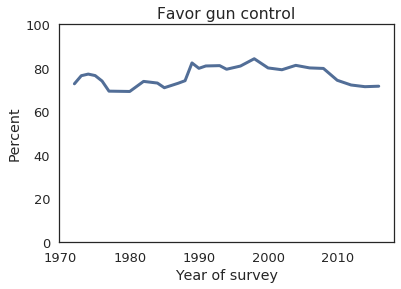

In [9]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor').dropna()
thinkplot.plot(favor)
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent', ylim=[0, 100],
                 title='Favor gun control')

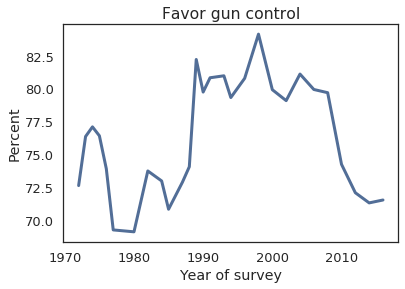

In [10]:
grouped_year = sample.groupby('year')
favor = make_series(grouped_year, 'favor').dropna()
thinkplot.plot(favor)
thinkplot.config(xlabel='Year of survey', 
                 ylabel='Percent',
                 title='Favor gun control')

In [11]:
favor_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('year')
    favor = make_series(grouped_year, 'favor').dropna()
    favor_seq.append(favor)

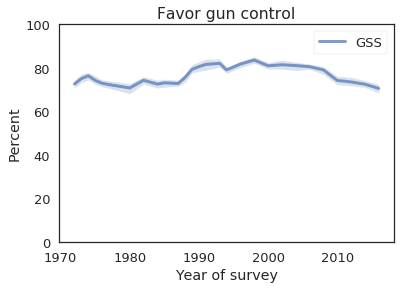

In [12]:
plot_percentiles(favor_seq, 'C0', 'GSS')

thinkplot.config(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=[0, 100])

In [13]:
ylim=[40, 100]

[40, 100]

Writing gss_year.pdf
Writing gss_year.png


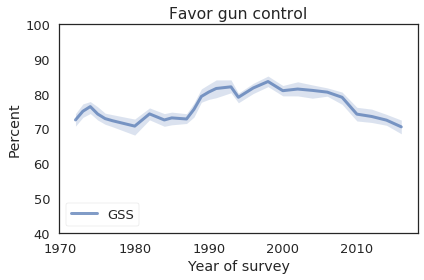

In [14]:
plot_percentiles(favor_seq, 'C0', 'GSS')

thinkplot.config(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim,
                 loc='lower left')

plt.tight_layout()
thinkplot.save('gss_year')

In [15]:
heri = pd.read_csv('heri_gun_control.csv')

,year,yearm18,agree,notes
0,1989,1971,79.8,The federal government should do more to control
1,1990,1972,79.5,the sale of handguns
2,1991,1973,80.9,Agree strongly or agree somewhat
3,1992,1974,82.4,NaN
4,1993,1975,83.0,NaN
5,1994,1976,81.6,NaN
6,1995,1977,82.8,NaN
7,1996,1978,82.9,NaN
8,1997,1979,83.2,NaN
9,1998,1980,84.1,NaN


In [16]:
def plot_heri(heri, x='year'):
    heri1 = heri.loc[:21]
    heri2 = heri.loc[22]
    thinkplot.plot(heri1[x], heri1.agree, color=ORANGE, label='CIRP')
    thinkplot.plot(heri2[x], heri2.agree, color=ORANGE, style='^')

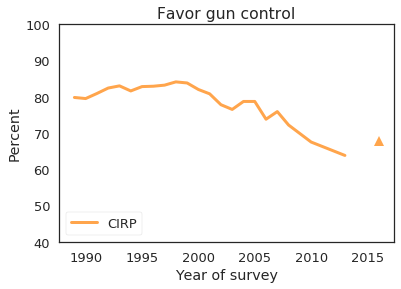

In [17]:
plot_heri(heri)

thinkplot.config(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)



Writing heri_year.pdf
Writing heri_year.png


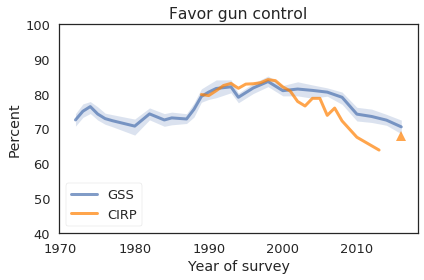

In [18]:
plot_percentiles(favor_seq, 'C0', 'GSS')
plot_heri(heri)

thinkplot.config(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim,
                 loc='lower left')

plt.tight_layout()
thinkplot.save('heri_year')

In [19]:
def read_pew():
    pew = pd.read_csv('Pew Gun Data - Sheet1.csv', header=None).transpose()
    pew = pew.drop(columns=[3])
    pew.columns = ['Date', 'Total rights', 'Total control']
    pew = pew.drop(0)
    date = pd.DatetimeIndex(pew.Date)
    pew.index = date.year + date.dayofyear / 365
    return pew

In [20]:
pew = read_pew()

,Date,Total rights,Total control
Date,,,
1993.928767,12/5/93,35,57
1999.372603,5/16/99,30,65
1999.452055,6/14/99,33,62
2000.216438,3/19/00,29,67
2000.293151,4/16/00,37,55
2000.347945,5/6/00,38,57
2003.435616,6/8/03,42,54
2004.128767,2/16/04,37,58
2007.306849,4/22/07,32,59


In [21]:
def plot_pew(pew):
    series = pew['Total control'].astype(int)
    thinkplot.plot(series.index, series, color='C1', label='Pew')

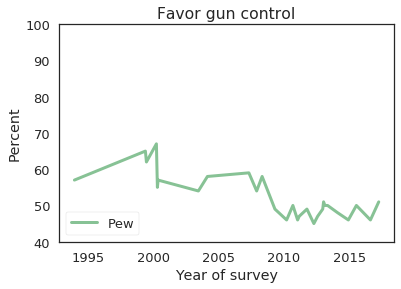

In [22]:
plot_pew(pew)

thinkplot.config(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)

Writing pew_year.pdf
Writing pew_year.png


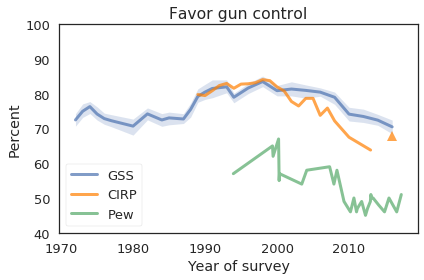

In [23]:
plot_percentiles(favor_seq, 'C0', 'GSS')
plot_heri(heri)
plot_pew(pew)

thinkplot.config(title='Favor gun control',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim,
                 loc='lower left')

plt.tight_layout()
thinkplot.save('pew_year')

## Plot by year of birth

In [24]:
ylim=[50, 100]

[50, 100]

In [25]:
favor_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('cohort5')
    favor = make_series(grouped_year, 'favor').dropna()
    favor_seq.append(favor)

Writing gss_cohort.pdf
Writing gss_cohort.png


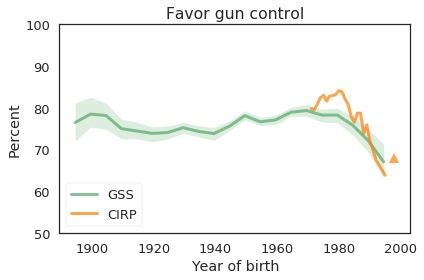

In [26]:
plot_percentiles(favor_seq, 'C1', 'GSS')
plot_heri(heri, 'yearm18')

thinkplot.config(title='Favor gun control',
                 xlabel='Year of birth', 
                 ylabel='Percent', ylim=ylim)

plt.tight_layout()
thinkplot.save('gss_cohort')

In [27]:
favor_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('age5')
    favor = make_series(grouped_year, 'favor').dropna()
    favor_seq.append(favor)

Writing gss_age.pdf
Writing gss_age.png


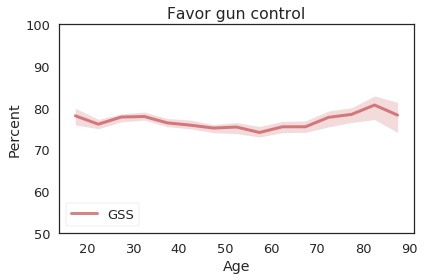

In [28]:
plot_percentiles(favor_seq, 'C2', 'GSS')

thinkplot.config(title='Favor gun control',
                 xlabel='Age', 
                 ylabel='Percent', ylim=ylim)

plt.tight_layout()
thinkplot.save('gss_age')

In [29]:
for sample in read_samples(1):
    pass

sample.shape

(40339, 67)

In [30]:
def make_result(sample, var1, var2, bad_names):
    percents = {}
    grouped_var1 = sample.groupby(var1)
    for name, group in grouped_var1:
        if name in bad_names:
            continue
        #print(name, len(group))
        grouped_var2 = group.groupby(var2)
        percents[name] = grouped_var2['favor'].mean() * 100
        
    return pd.DataFrame(percents)

In [31]:
def make_counts(sample, var1, var2):
    counts = {}
    grouped_var1 = sample.groupby(var1)
    for name, group in grouped_var1:
        grouped_var2 = group.groupby(var2)
        counts[name] = grouped_var2['favor'].count()
        
    return pd.DataFrame(counts)

## Grouped by cohort, plotted by year

In [59]:
plt.rcParams["figure.figsize"] = (7.5,4)

Float64Index([1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0], dtype='float64')


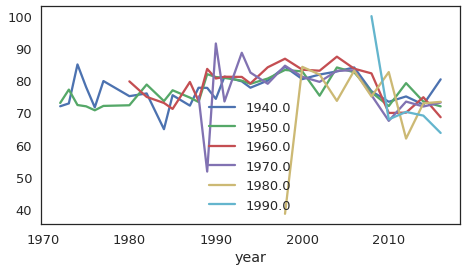

In [92]:
badnames = [1880, 1890, 1900, 1910, 1920, 1930]
result = make_result(sample, 'cohort10', 'year', badnames)
result.plot()
print(result.columns)

In [93]:
counts = make_counts(sample, 'cohort10', 'year')

,1880.0,1890.0,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0
year,,,,,,,,,,,,
1972,9.0,76.0,152.0,247.0,333,222,335,185,NaN,NaN,NaN,NaN
1973,1.0,61.0,140.0,232.0,281,288,276,188,NaN,NaN,NaN,NaN
1974,8.0,36.0,169.0,218.0,292,218,306,206,NaN,NaN,NaN,NaN
1975,6.0,43.0,113.0,198.0,285,246,294,260,NaN,NaN,NaN,NaN
1976,16.0,45.0,114.0,220.0,244,228,310,290,NaN,NaN,NaN,NaN
1977,1.0,37.0,120.0,194.0,299,247,297,297,NaN,NaN,NaN,NaN
1980,NaN,16.0,82.0,167.0,219,255,281,346,64.0,NaN,NaN,NaN
1982,NaN,31.0,102.0,196.0,282,269,266,479,179.0,NaN,NaN,NaN
1984,NaN,9.0,54.0,113.0,194,216,287,329,222.0,NaN,NaN,NaN


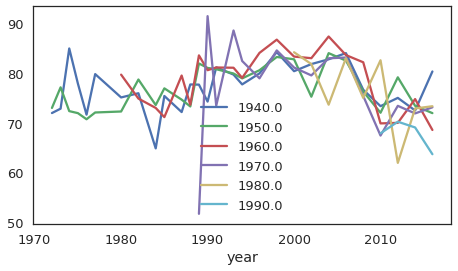

In [94]:
result = result[counts>20]
result.plot()


In [95]:
result_seq = [make_result(sample, 'cohort10', 'year', badnames)
              for sample in read_samples()];

In [96]:
result_seq = [result[counts>20] for result in result_seq];

In [97]:
def cohort_label(column):
    return '%0.0fs' % column

def age_label(column):
    return '%0.0fs' % (column-5)

Writing gss_cohort_year.pdf
Writing gss_cohort_year.png


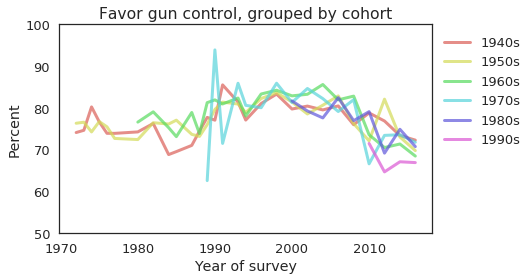

In [98]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = cohort_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

thinkplot.config(title='Favor gun control, grouped by cohort',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)

def savefig(root):
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.tight_layout()
    thinkplot.save(root)
    
savefig('gss_cohort_year')

## Grouped by age, plotted by year

Float64Index([15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0], dtype='float64')


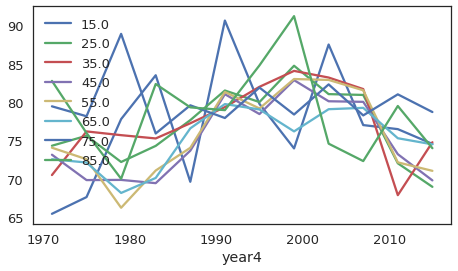

In [79]:
badnames = []
result = make_result(sample, 'age10', 'year4', badnames)
result.plot()
print(result.columns)

In [80]:
result_seq = [make_result(sample, 'age10', 'year4', badnames)
              for sample in read_samples()];

Writing gss_age_year.pdf
Writing gss_age_year.png


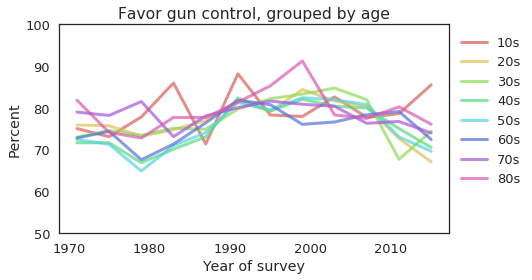

In [81]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = age_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

thinkplot.config(title='Favor gun control, grouped by age',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_age_year')

## Grouped by cohort, plotted by age

Float64Index([1930.0, 1940.0, 1950.0, 1960.0, 1970.0, 1980.0, 1990.0], dtype='float64')


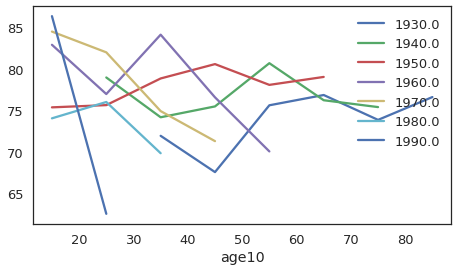

In [39]:
badnames = [1880.0, 1890.0, 1900.0, 1910.0, 1920.0]
result = make_result(sample, 'cohort10', 'age10', badnames)
result.plot()
print(result.columns)

In [40]:
result_seq = [make_result(sample, 'cohort10', 'age10', badnames)
              for sample in read_samples()];

Writing gss_cohort_age.pdf
Writing gss_cohort_age.png


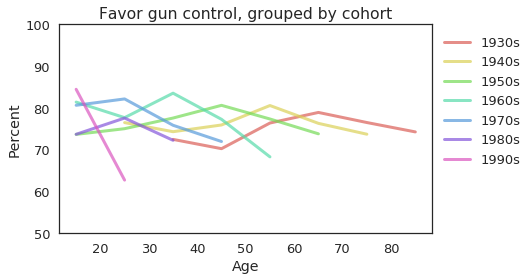

In [41]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = cohort_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

thinkplot.config(title='Favor gun control, grouped by cohort',
                 xlabel='Age', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_cohort_age')

## Grouped by year, plotted by age

Int64Index([1968, 1976, 1984, 1992, 2000, 2008, 2016], dtype='int64')


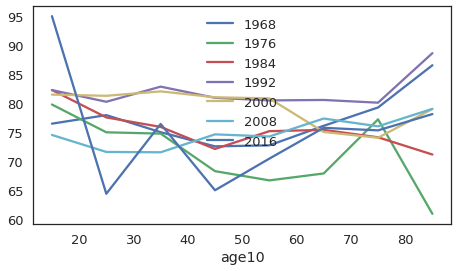

In [42]:
badnames = []
result = make_result(sample, 'year8', 'age10', badnames)
result.plot()
print(result.columns)

In [99]:
counts = make_counts(sample, 'year8', 'age10')

,1968,1976,1984,1992,2000,2008,2016
age10,,,,,,,
15.0,188,148,196,153,129,134,15
25.0,1398,1485,1932,1348,1080,979,273
35.0,983,1160,1943,1581,1080,940,349
45.0,1132,1034,1522,1445,1182,1138,336
55.0,1102,1066,1083,932,931,1054,398
65.0,691,721,1019,633,611,705,276
75.0,359,455,614,453,360,409,140
85.0,71,124,217,172,194,203,63


In [100]:
result_seq = [make_result(sample, 'year8', 'age10', badnames)
              for sample in read_samples()];

In [101]:
result_seq = [result[counts>20] for result in result_seq];

Writing gss_year_age.pdf
Writing gss_year_age.png


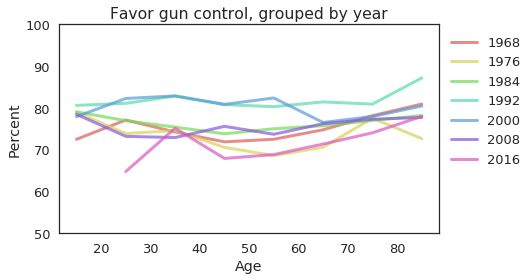

In [102]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = column
    plot_percentiles(series_seq, colors[i], label, fill=False)

thinkplot.config(title='Favor gun control, grouped by year',
                 xlabel='Age', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_year_age')

## Grouped by year, plotted by cohort

Int64Index([1968, 1976, 1984, 1992, 2000, 2008, 2016], dtype='int64')


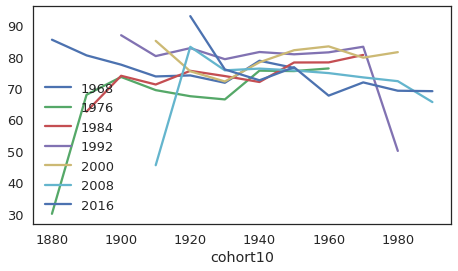

In [45]:
badnames = []
result = make_result(sample, 'year8', 'cohort10', badnames)
result.plot()
print(result.columns)

In [46]:
result_seq = [make_result(sample, 'year8', 'cohort10', badnames)
              for sample in read_samples()];

Writing gss_year_cohort.pdf
Writing gss_year_cohort.png


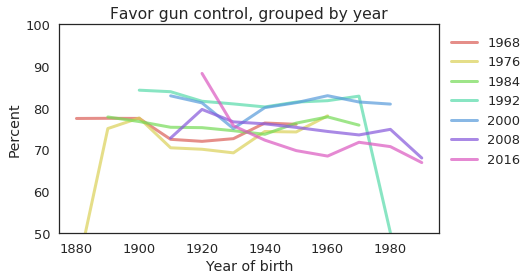

In [47]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = column
    plot_percentiles(series_seq, colors[i], label, fill=False)

thinkplot.config(title='Favor gun control, grouped by year',
                 xlabel='Year of birth', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_year_cohort')

## Grouped by age, plotted by cohort

Float64Index([15.0, 25.0, 35.0, 45.0, 55.0, 65.0, 75.0, 85.0], dtype='float64')


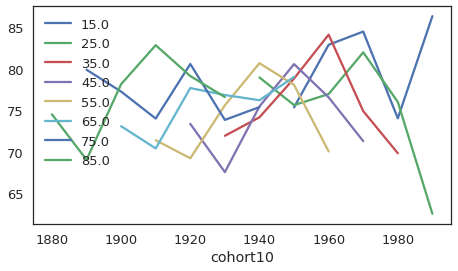

In [48]:
badnames = []
result = make_result(sample, 'age10', 'cohort10', badnames)
result.plot()
print(result.columns)

In [49]:
result_seq = [make_result(sample, 'age10', 'cohort10', badnames)
              for sample in read_samples()];

Writing gss_age_cohort.pdf
Writing gss_age_cohort.png


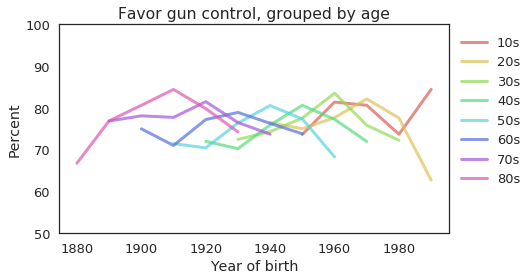

In [50]:
columns = result_seq[0].columns
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series_seq = [result[column] for result in result_seq]
    label = age_label(column)
    plot_percentiles(series_seq, colors[i], label, fill=False)

thinkplot.config(title='Favor gun control, grouped by age',
                 xlabel='Year of birth', 
                 ylabel='Percent', ylim=ylim)

savefig('gss_age_cohort')

## Pew data

In [51]:
def read_pew():
    pew = pd.read_csv('Pew Gun Data - Sheet2.csv', header=None).transpose()
    pew = pew.drop(columns=[1,3,5,7])
    pew.columns = ['Date', 'Silent', 'Boomer', 'Gen X', 'Millennial']
    pew = pew.drop(0)
    date = pd.DatetimeIndex(pew.Date)
    pew.index = date.year + date.dayofyear / 365
    pew.replace(['--'], np.nan, inplace=True)
    return pew

In [52]:
pew = read_pew()

,Date,Silent,Boomer,Gen X,Millennial
Date,,,,,
1993.928767,12/5/93,53,59,64,NaN
1999.372603,5/16/99,56,62,73,NaN
1999.452055,6/14/99,56,59,70,NaN
2000.216438,3/19/00,61,63,72,NaN
2000.293151,4/16/00,57,52,60,NaN
2000.347945,5/6/00,51,53,65,NaN
2003.435616,6/8/03,48,51,59,65
2004.128767,2/16/04,52,54,63,72
2007.306849,4/22/07,56,56,60,74


Writing pew_cohort_year.pdf
Writing pew_cohort_year.png


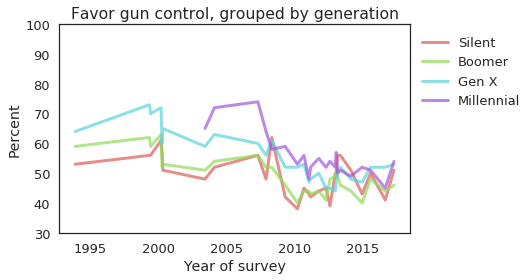

In [53]:
columns = pew.columns[1:]
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series = pew[column].astype(float)
    thinkplot.plot(series.index, series.values, color=colors[i], label=column)

thinkplot.config(title='Favor gun control, grouped by generation',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=[30, 100])

savefig('pew_cohort_year')

In [54]:
def read_pew():
    pew = pd.read_csv('Pew Gun Data - Sheet3.csv', header=None).transpose()
    pew = pew.drop(columns=[1,3,5,7])
    pew.columns = ['Date', '18-29', '30-49', '50-64', '65+']
    pew = pew.drop(0)
    date = pd.DatetimeIndex(pew.Date)
    pew.index = date.year + date.dayofyear / 365
    return pew

In [55]:
pew = read_pew()

,Date,18-29,30-49,50-64,65+
Date,,,,,
1993.928767,12/5/93,64,57,55,49
1999.372603,5/16/99,71,65,59,61
1999.452055,6/14/99,74,60,55,62
2000.216438,3/19/00,77,63,61,68
2000.293151,4/16/00,64,53,51,51
2000.347945,5/6/00,65,57,49,53
2003.435616,6/8/03,63,55,50,48
2004.128767,2/16/04,69,58,52,53
2007.306849,4/22/07,71,58,55,58


Writing pew_age_year.pdf
Writing pew_age_year.png


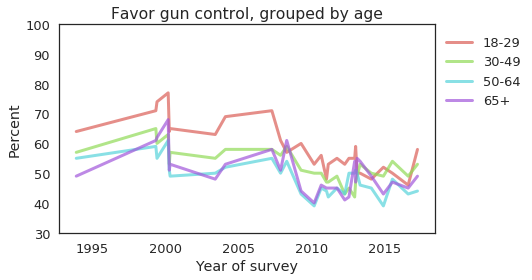

In [56]:
columns = pew.columns[1:]
colors = sns.color_palette('hls', len(columns))

for i, column in enumerate(columns):
    series = pew[column].astype(float)
    thinkplot.plot(series.index, series.values, color=colors[i], label=column)

thinkplot.config(title='Favor gun control, grouped by age',
                 xlabel='Year of survey', 
                 ylabel='Percent', ylim=[30, 100])

savefig('pew_age_year')

## Relationship to crime

In [57]:
favor_seq = []
crime_seq = []

for sample in read_samples(101):
    grouped_year = sample.groupby('year')
    favor = make_series(grouped_year, 'favor').dropna()
    crime = make_series(grouped_year, 'spendcrime')

    favor_seq.append(favor)
    crime_seq.append(crime)

Writing gss_crime.pdf
Writing gss_crime.png


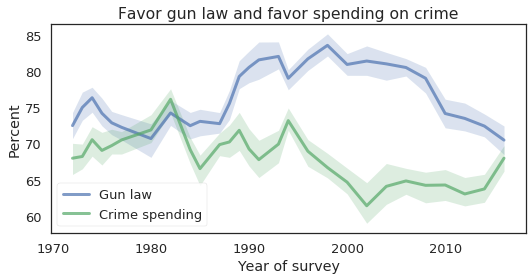

In [68]:
plot_percentiles(favor_seq, 'C0', 'Gun law')
plot_percentiles(crime_seq, 'C1', 'Crime spending')

thinkplot.config(title='Favor gun law and favor spending on crime',
                 xlabel='Year of survey', 
                 ylabel='Percent')

plt.tight_layout()
thinkplot.save('gss_crime')